## Classifying movie reviews: A binary classification example

### The IMDB dataset



---


The IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.
Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has
already been preprocessed: the reviews (sequences of words) have been turned into
sequences of integers, where each integer stands for a specific word in a dictionary.
This enables you to focus on model building, training, and evaluation.

---



**Loading the IMDB dataset**

In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


The argument num_words=10000 means you’ll only keep the top 10,000 most frequently
occurring words in the training data. Rare words will be discarded. This allows
us to work with vector data of manageable size. If we didn’t set this limit, we’d be working
with 88,585 unique words in the training data, which is unnecessarily large. Many
of these words only occur in a single sample, and thus can’t be meaningfully used for
classification.

In [2]:
train_data.shape

(25000,)

The variables train_data and test_data are lists of reviews; each review is a list of
word indices (encoding a sequence of words).

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

train_labels and test_labels are
lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [4]:
train_labels[0]

np.int64(1)

Because we’re restricting ourselves to the top 10,000 most frequent words, no word
index will exceed 10,000:

In [5]:
max([max(sequence) for sequence in train_data])

9999

**Decoding reviews back to text**

For kicks, here’s how you can quickly decode one of these reviews back to English words.

In [6]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Preparing the data

You can’t directly feed lists of integers into a neural network. They all have different
lengths, but a neural network expects to process contiguous batches of data. You have
to turn your lists into tensors. There are two ways to do that:
  

*   Pad your lists so that they all have the same length, turn them into an integer
tensor of shape (samples, max_length), and start your model with a layer capable
of handling such integer tensors.
*  Multi-hot encode your lists to turn them into vectors of 0s and 1s. This would
mean, for instance, turning the sequence [8, 5] into a 10,000-dimensional vector
that would be all 0s except for indices 8 and 5, which would be 1s. Then you
could use a Dense layer, capable of handling floating-point vector data, as the
first layer in your model.



Let’s go with the latter solution to vectorize the data, which you’ll do manually for
maximum clarity.

**Encoding the integer sequences via multi-hot encoding**

In [7]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Here’s what the samples look like now:

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.], shape=(10000,))

You should also vectorize your labels, which is straightforward:

In [9]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building your model



---


The input data is vectors, and the labels are scalars (1s
and 0s): this is one of the simplest
problem setups you’ll ever encounter.:

---



**Model definition**

1. Create a sequential model with three dense layers, two hidden and one for output. Make the output size of the hidden layers 16 each and carrefully choose the activation functions and the output size of the last layer.

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    keras.Input(shape=(10000,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

**Compiling the model**

In [13]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

2. Create the validation set with he first 10000 sample of the dataset.

In [14]:
import numpy as np

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

**Training your model**

3. Train the model for 20 epochs and batch-size 512

In [15]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7715 - loss: 0.5567 - val_accuracy: 0.8531 - val_loss: 0.4376
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8911 - loss: 0.3515 - val_accuracy: 0.8757 - val_loss: 0.3363
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9134 - loss: 0.2625 - val_accuracy: 0.8891 - val_loss: 0.2911
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9300 - loss: 0.2098 - val_accuracy: 0.8889 - val_loss: 0.2765
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9422 - loss: 0.1756 - val_accuracy: 0.8833 - val_loss: 0.2900
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9517 - loss: 0.1480 - val_accuracy: 0.8839 - val_loss: 0.2882
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9592 - loss: 0.1294 - val_accuracy: 0.8732 - val_loss: 0.3194
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9686 - loss: 0.1093 - val_accuracy: 0.8819 - val_loss

**Plotting the training and validation loss and accuracy**

4. Plot the results (you will use the History object). Example:

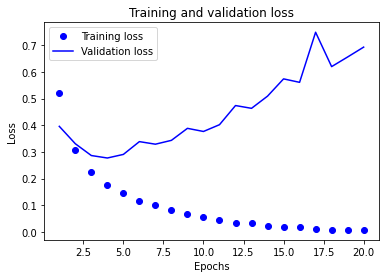
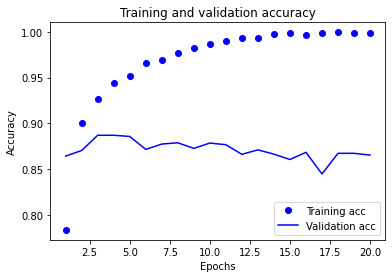

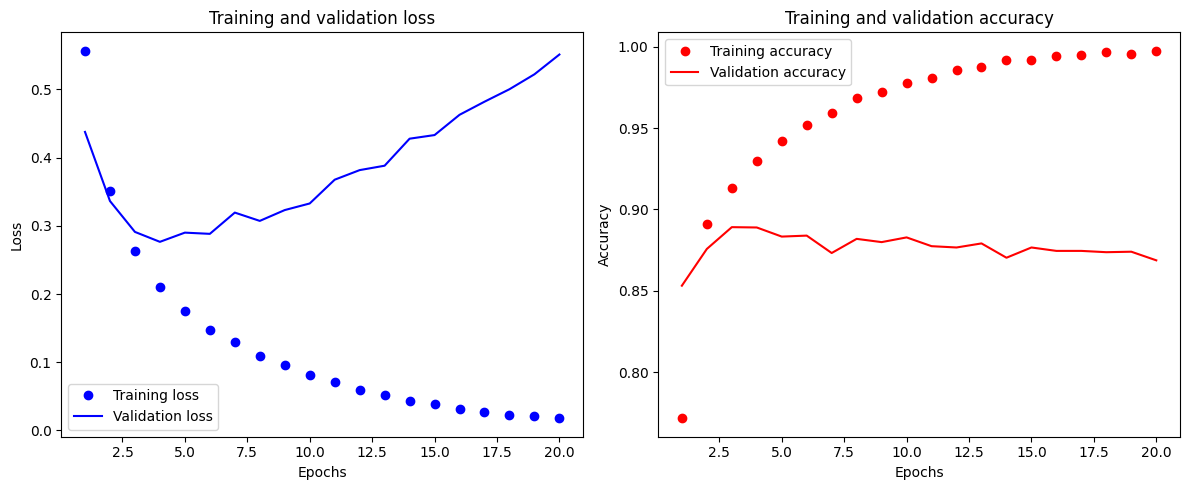

In [17]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Using a trained model to generate predictions on new data

**Retraining a model from scratch**

5. Retrain with : (a) different batch-sizes, (b) different number of epochs (4/10/30), (c) smaller training sets (100/1000/6000/10000) and combination of these 3. Also, create different models with (d) more layers, (e) smaller layers and train them for different scenarios from above (batch-size, epochs and size of training set).

6. What do you observe?

7. Plot the results for each of your experiments.